# 16-4. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

2023-02-13 10:35:32.590227: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /Users/songye/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2023-02-13 10:35:44.356558: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 10:35:45.894325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-13 10:35:45.988140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


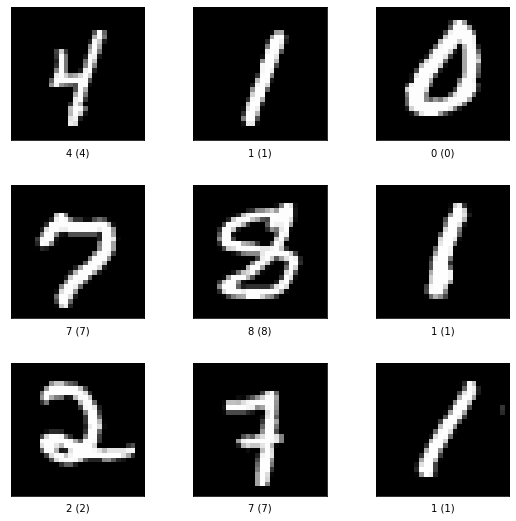

In [1]:
import tensorflow_datasets as tfds

mnist,info = tfds.load(
    "mnist",split = "train",with_info=True)

fig = tfds.show_examples(mnist,info)

In [2]:
import tensorflow as tf
BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data['image']
    image = tf.cast(image,tf.float32)
    image = (image/127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data['image']
    image = tf.cast(image,tf.float32)
    image = (image / 127.5) -1
    label = tf.one_hot(data['label'],10)
    return image,label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("COMPLETED!")

COMPLETED!


label :  tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
image min/max :  -1.0 1.0


2023-02-13 10:41:24.325466: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


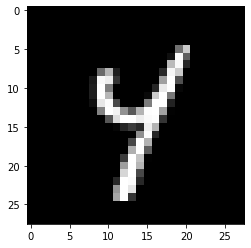

In [6]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break
    
print("label : ",j[0])
print("image min/max : ",i.numpy().min(),i.numpy().max())
plt.imshow(i.numpy()[0,...,0],plt.cm.gray)

### GAN Generator 구성하기

In [20]:
from tensorflow.keras import layers,Input,Model

class GeneratorGAN(Model):
    def __init__(self): #레이어 구성 정의
        super(GeneratorGAN,self).__init__()
        
        self.dense_1 = layers.Dense(128,activation='relu')
        self.dense_2 = layers.Dense(256,activation='relu')
        self.dense_3 = layers.Dense(512,activation='relu')
        self.dense_4 = layers.Dense(28*28*1,activation='tanh')
        self.reshape = layers.Reshape((28,28,1))
        
    def call(self,noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)
    
    
print("complete")

complete


### cGAN Generator 구성하기

In [44]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


# 16-5. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

### GAN Discriminator 구성하기

In [24]:
class DiscrminatorGAN(Model):
    def __init__(self):
        super(DiscrminatorGAN,self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512,256,128,1]:
            self.blocks.append(
                layers.Dense(f,activation=None if f==1 else "relu")
            )
            
    def call(self,x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

### cGAN Discriminator 구성하기

In [45]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


In [46]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


# 16-6. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

### loss function, optimizers 정의

In [12]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output),fake_output)

def discriminator_loss(real_output,fake_output):
    return bce(tf.ones_like(real_output),real_output)+bce(tf.zeros_like(fake_output),fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

print("completed!")

completed!


### GAN으로 MNIST 학습하기

In [25]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscrminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0],100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = gan_generator(noise)
        real_output = gan_discriminator(real_images)
        fake_output = gan_discriminator(fake_images)
        gene_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    
    gene_grad = tape.gradient(gene_loss,gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss,gan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad,gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad,gan_discriminator.trainable_variables))
    return gene_loss,disc_loss

print("completed!")
        

completed!


In [26]:
EPOCHS = 10
for epoch in range(1,EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss,disc_loss = gan_step(images)
        
        if (i+1) %100==0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.3127567768096924, D:0.11631350964307785
[1/10 EPOCHS, 200 ITER] G:2.3257861137390137, D:0.1358853131532669
[1/10 EPOCHS, 300 ITER] G:3.259782314300537, D:0.0883025974035263
[1/10 EPOCHS, 400 ITER] G:2.469808578491211, D:0.1824045181274414
[2/10 EPOCHS, 100 ITER] G:2.836068630218506, D:0.30939874053001404
[2/10 EPOCHS, 200 ITER] G:2.405855178833008, D:0.3379463851451874
[2/10 EPOCHS, 300 ITER] G:3.883671283721924, D:0.09675036370754242
[2/10 EPOCHS, 400 ITER] G:2.7917866706848145, D:0.12356650829315186
[3/10 EPOCHS, 100 ITER] G:2.864229202270508, D:0.2601901888847351
[3/10 EPOCHS, 200 ITER] G:2.5469741821289062, D:0.1772558093070984
[3/10 EPOCHS, 300 ITER] G:3.1169469356536865, D:0.18643268942832947
[3/10 EPOCHS, 400 ITER] G:3.189284324645996, D:0.14063455164432526
[4/10 EPOCHS, 100 ITER] G:3.243772506713867, D:0.09947977215051651
[4/10 EPOCHS, 200 ITER] G:3.458488941192627, D:0.09135502576828003
[4/10 EPOCHS, 300 ITER] G:1.2223360538482666, D:0.7108789682388

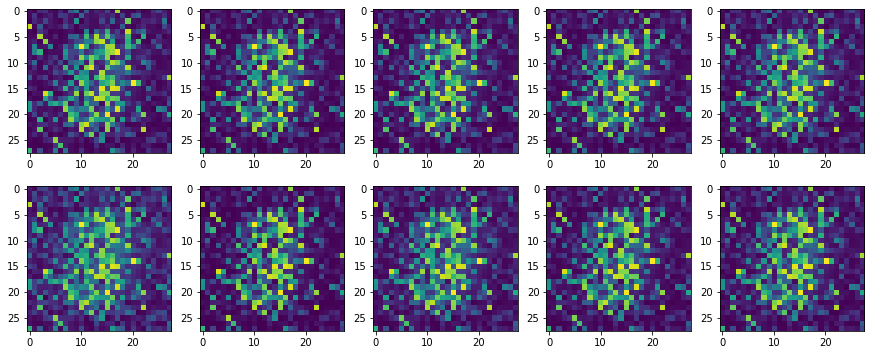

In [27]:
import numpy as np
noise = tf.random.normal([10,100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

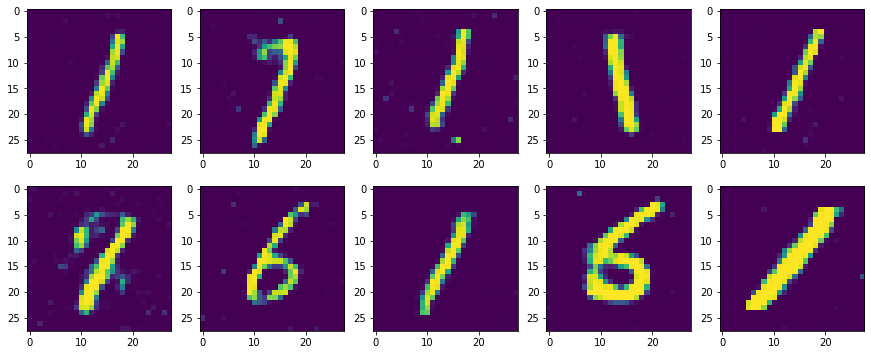

In [40]:
import os
weight_path = './gan/GAN_500'

noise = tf.random.normal([10, 100]) 
gan_generator = GeneratorGAN()
gan_generator.built = True
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기

In [47]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.054632186889648, D:0.0034875108394771814
[1/1 EPOCHS, 199 ITER] G:5.7560954093933105, D:0.004413786809891462
[1/1 EPOCHS, 299 ITER] G:5.381412506103516, D:0.023679625242948532
[1/1 EPOCHS, 399 ITER] G:5.196703910827637, D:0.009016485884785652


### 500 epoch 학습한 가중치로 내가 원하는 숫자 생성하기 

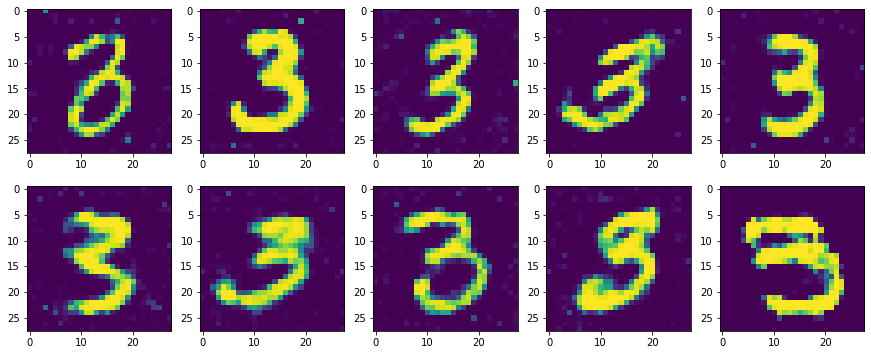

In [49]:
number = 3
weight_path = './cgan/CGAN_500'
noise = tf.random.normal([10,100])

label = tf.one_hot(number,10)
label = tf.expand_dims(label,axis=0)
label = tf.repeat(label,10,axis=0)


generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise,label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])